# Todo

* Train Encoder with different weights
* Train end-to-end
* Get images for poster
* Refactor and simplify code

$$L = \underbrace{\displaystyle \mathop{\mathbb{E}}_{\tilde{x} \sim \mathbb{P}_g} [D(\tilde{x})] - 
\displaystyle \mathop{\mathbb{E}}_{{x} \sim \mathbb{P}_r}[D(x)]}_{\text{critic loss}} + 
\underbrace{\lambda \displaystyle \mathop{\mathbb{E}}_{\hat{x} \sim \mathbb{P}_{\hat{x}}} [(\parallel \nabla_{\tilde{x}}  D(\hat{x})\parallel_2 - 1)^2]\displaystyle}_{\text{gradient penalty}}$$

Use: https://www.codecogs.com/latex/eqneditor.php for high quality image of formula

# Hyper-parameters

In [0]:
import os

# Iterations and data size
N_GEN_ITERS      = 100000    # Total number of generator iterations (used instead of epochs/batches) - can be arbitrarily large because checkpointing (and copying to persistent storage) happens during the training loop
N_ENCODER_ITERS  = 10000     # Number of iterations for which to train the encoder network on its own
D_ITERS          = 5         # Number of iterations of discriminator per iteration of generator
D_ITERS_START    = 100       # Number of iterations to train for at the start
BATCH_SIZE       = 32        # Number of data samples per batch
CUBE_LENGTH      = 32        # Dimension of dataset samples
OBJ              = 'chair'   # Name of a class of objects in the 3DShapeNets dataset

# Using learing rate from https://github.com/EmilienDupont/wgan-gp/blob/master/main.py#L17
LR               = 1e-4
G_LR             = LR
D_LR             = LR
E_LR             = LR
# Encoder loss function weights
# loss_recon is on the order of 5e-2 and loss_critic is on the order of 1e2
# therefore, for a 50/50 weighting, alpha1:alpha2 should be 1e2:5e-2
ALPHA1            = 5 * 1e2       # reconstruction loss weight
ALPHA2            = 5e-2      # critic loss
GRAD_PENALTY     = 10 # Gradient penalty from WGAN-GP paper

# Latent Vector
# Todo: check whether limiting range of latent vector (e.g. 0.33) is useful
Z_SIZE               = 200   # dimension of the latent space input to generator
LATENT_VEC_LOWER_LIM = 0     # lower bound of random sampling of latent vec z
LATENT_VEC_UPPER_LIM = 0.33  # upper bound of random sampling of latent vec z

# Data paths and checkpointing
RESUME_FROM_CHECKPOINT = True
CHECKPOINT_FREQ        = 1000    # Frequency of checkpoints (e.g. save a checkpoint every n generator iteration)
CHECKPOINT_PATH        = "/content/3dgan-pytorch/models/BREND-GAN_checkpoint_gen-iter8002_enc-iter6000_20191012-0907h.tar"
NETWORK_ID             = "BREND-GAN" # string to use in save names to distinguish this network's output from others'
IMAGE_SAVE_FREQ        = 250

# Use this Google Drive directory
DRIVE_ROOT_DIR      = '/content/gdrive/My\ Drive/ECE4095-FYP/3dgan-pytorch'
DRIVE_MODEL_DIR     = os.path.join(DRIVE_ROOT_DIR, 'models')

# Make these directories:
ROOT                = '/content/3dgan-pytorch'
DATA_ROOT_DIR       = os.path.join(ROOT, 'data')
MODEL_DIR           = os.path.join(ROOT, 'models') # Directory to save models/checkpoints
TEST_IMG_DIR        = os.path.join(ROOT, 'test_imgs')

# Get data from this directory
VOLUMETRIC_DATA_DIR = os.path.join(DATA_ROOT_DIR, '3DShapeNets/volumetric_data')# do not need to make directory because it is already in 33DShapeNets zip file

# Setup

## Mount Google Drive to Session

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


## Copy data from Drive

In [0]:
if not os.path.exists(ROOT):
    print('Making directory {}...'.format(ROOT))
    os.makedirs(ROOT)

if not os.path.exists(DATA_ROOT_DIR):
    print('Making directory {}...'.format(DATA_ROOT_DIR))
    os.makedirs(DATA_ROOT_DIR)

if not os.path.exists(MODEL_DIR):
    print('Making directory {}...'.format(MODEL_DIR))
    os.makedirs(MODEL_DIR)

if not os.path.exists(TEST_IMG_DIR):
    print('Making directory {}...'.format(TEST_IMG_DIR))
    os.makedirs(TEST_IMG_DIR)

Making directory /content/3dgan-pytorch...
Making directory /content/3dgan-pytorch/data...
Making directory /content/3dgan-pytorch/models...
Making directory /content/3dgan-pytorch/test_imgs...


### Copy checkpoints from Google Drive

In [0]:
%%bash -s "$RESUME_FROM_CHECKPOINT" "$DRIVE_MODEL_DIR" "$MODEL_DIR"
echo "RESUME_FROM_CHECKPOINT: $1"
echo "DRIVE_MODEL_DIR: $2"

# if RESUME_FROM_CHECKPOINT is True:
if [ "${1}" = "True" ]
then
  # copy checkpoints from Google Drive to local computer
  echo "Copying checkpoints from Google Drive to local computer..."
  #cp "${2}/." "${3}"
  cp -a "/content/gdrive/My Drive/ECE4095-FYP/3dgan-pytorch/models/." "${3}"
  echo "Done."
fi

RESUME_FROM_CHECKPOINT: True
DRIVE_MODEL_DIR: /content/gdrive/My\ Drive/ECE4095-FYP/3dgan-pytorch/models
Copying checkpoints from Google Drive to local computer...
Done.


## Download and Extract Dataset

In [0]:
%%bash

# cd to DATA_ROOT_DIR
cd /content/3dgan-pytorch/data

if [ -d 3DShapeNets ]
  then
    echo "3DShapeNets data set already exists."
  else
    echo "3DShapeNets data set does not exist."
  
    if [ -f 3DShapeNetsCode.zip ]
    then
      echo "3DShapeNetsCode.zip file exists."
    else
      echo "3DShapeNetsCode.zip file does not exist."
      echo "Downloading 3DShapeNets data set..."
      wget -q http://3dshapenets.cs.princeton.edu/3DShapeNetsCode.zip
    fi
  
    echo "Unzipping 3DShapeNets zip file..."
    unzip -q 3DShapeNetsCode.zip
  #echo "Removing 3DShapeNets zip file..."
  #rm 3DShapeNetsCode.zip
  echo "Done."
fi

3DShapeNets data set does not exist.
3DShapeNetsCode.zip file does not exist.
Unzipping 3DShapeNets zip file...
Done.


## Import packages

In [0]:
# Install any required python packages
#!pip3 install numpy-stl

import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
import time

# Used in data processing
import scipy.io as io
import scipy.ndimage as nd

# Visualization
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from skimage.color import hsv2rgb

## Process dataset and instantiate data loader

### Convert MATLAB file format to Numpy file format

In [0]:
def matfile_to_nparray(path):
    if(path.endswith('.mat')):
       appendmat = False
    else:
       appendmat = True
       
    data = io.loadmat(path, appendmat=False, verify_compressed_data_integrity=False)
    values = data['instance']
    return values

def upsample(voxels, factor):
    padded = np.pad(voxels,(1,1),'constant',constant_values=(0,0))
    interpolated = nd.zoom(padded, (factor,factor,factor), mode='constant', order=1)
    return interpolated

"""
path: path to '/3DShapeNets/volumetric_data' directory
obj: type of object to get (must be a directory name in /volumetric_data
train: Use 'train' data set. If False, uses 'test' data set
obj_ratio: 
"""
def get_data(path, obj='airplane',train=True, obj_ratio=1.0, upsampleTo64=False):
    if ((obj_ratio >1) or (obj_ratio<= 0 )):
        raise ValueError("obj_ratio parameter is the subset of voxel arrays to get and must be between 0 and 1 (e.g. set obj_ratio to 0.1 to get 10% of the total). Default is get all (i.e. obj_ratio = 1.0).")
        
    if (not os.path.exists(path)):
        raise ValueError("Path {} doesn't exist. Path should be relative or absolute path to '/3DShapeNets/volumetric_data/' directory ".format(path))
        
    if (not path.endswith('/')):
        path = path + '/'
    
    objPath = path + obj + '/30/'
    objPath += 'train/' if train else 'test/'
    
    print("Getting voxel arrays from {}...".format(objPath))
    
    fileList = [f for f in os.listdir(objPath) if f.endswith('.mat')]
    print("{} voxel arrays found.".format(len(fileList)))
    
    fileListSet = fileList[0:int(obj_ratio*len(fileList))]
    print("Getting {}/{} voxel arrays (note: use obj_ratio arg in get_data() to get a subset)...".format(len(fileListSet),len(fileList)))
    
    files = [matfile_to_nparray(objPath + f) for f in fileListSet]
    
    if upsampleTo64:
        upsampled = [upsample(file,2) for file in files]
        voxelBatch = np.asarray(upsampled,dtype=np.bool)
    else:
        upsampled = [upsample(file,1) for file in files]
        voxelBatch = np.asarray(upsampled,dtype=np.bool)
    
    print('Got {} voxel arrays.'.format(len(files),objPath))
    
    return voxelBatch

### Create Dataset class to pass to loader constructor

In [0]:
"""
Dataset class that can be passed to a constructor for DataLoader
"""
class ShapenetDataset(Dataset):
    def __init__(self, x):
        x_dtype = torch.FloatTensor
        self.length = x.shape[0]
        self.x_data = torch.from_numpy(x).type(x_dtype)

    def __getitem__(self, index):
        return self.x_data[index]

    def __len__(self):
        return self.length

#data_train = data_io.get_data(DATA_ROOT_DIR, obj=OBJ,train=True, obj_ratio=0.1)
print("CUBE_LENGTH: {}".format(CUBE_LENGTH))
if CUBE_LENGTH == 32:
  data_train = get_data(VOLUMETRIC_DATA_DIR, obj=OBJ,train=True, obj_ratio=0.1, upsampleTo64=False)
elif CUBE_LENGTH == 64:
  data_train = get_data(VOLUMETRIC_DATA_DIR, obj=OBJ,train=True, obj_ratio=0.1, upsampleTo64=True)
else:
  raise ValueError("CUBE_LENGTH parameter must be 32 or 64.")
dataset_train = ShapenetDataset(x=data_train)

# Instantiate DataLoader object
data_loader_train = DataLoader(dataset=dataset_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

CUBE_LENGTH: 32
Getting voxel arrays from /content/3dgan-pytorch/data/3DShapeNets/volumetric_data/chair/30/train/...
10668 voxel arrays found.
Getting 1066/10668 voxel arrays (note: use obj_ratio arg in get_data() to get a subset)...
Got 1066 voxel arrays.


### Function to get 2D view of voxel grid

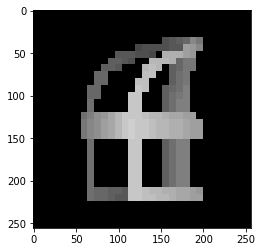

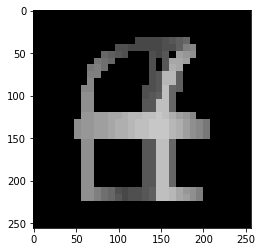

In [0]:
def get_2d_view(voxels,dir='front',output='tensor'):
  """
  dir can be 'front' or 'side'
  
  Example usage:
  data = next(iter(data_loader_train))
  data.cuda()

  voxels = data

  img1 = get_2d_view(voxels,dir='front',output='numpy')

  plt.figure()
  plt.imshow(img1[0,...])
  
  reminder: voxels is a tensor object voxels batch, size = [32,32,32,32]
  
  """
  # Transfer voxels to cpu (todo: make work with cuda)
  voxels = voxels.cpu().numpy()
  np.reshape(voxels,[32,32,32,32])
  
  # flip height axis
  voxels = np.flip(voxels,3)
  
  if(dir=='front'):
    voxels = np.transpose(voxels, (0,3,2,1))
  elif(dir=='side'):
    voxels = np.transpose(voxels, (0,3,1,2))
  # angle 1
  # Create 2.5 Image from 3D volume using ray casting/tracing
  img = np.zeros([32,32,32])
  for batch_idx in range(32):
    for row in range(32):
      for col in range(32):
        # return the longitudinal row of voxels
        ray = voxels[batch_idx,row,col,:] #row,col,dep
        # the index of the first non-zero value from a given direction
        dep0 = np.argmax(ray > 0) # get first value along the 3rd axis (depth axis)
        # np.argmax returns 0 if it doesn't find element matching condition
        if(dep0==0):
          dep0=32
        img[batch_idx,row,col] = dep0
  
  # normalise
  img = img/32
  
  # make distant images darker
  img = 1 - img
  
  # change dims from 32x32 to 3x32x32
  # upsample from 32x32 to 256x256
  img = img.repeat(8, 1).repeat(8, 2)
  # broadcast over 3 channels (RGB)
  img = np.expand_dims(img,1) + np.zeros((32,3,256,256))
  
  if(output == 'tensor'):
    # send back to GPU as a pytorch tensor
    img = torch.from_numpy(img).float().cuda()
  elif(output == 'numpy'):
    # change from 32x3xHxW to 32xHxWx3
    img = np.transpose(img,(0,2,3,1))
  
  return img

# Get a batch of data
data = next(iter(data_loader_train))
data.cuda()

voxels = data

img1 = get_2d_view(voxels,dir='front',output='numpy')
img2 = get_2d_view(voxels,dir='side',output='numpy')

plt.figure()
plt.imshow(img1[0,...])

plt.figure()
plt.imshow(img2[0,...])

# Models

## Generator

In [0]:
class Generator(nn.Module):
    def __init__(self):
        # Perform initialization of the pytorch superclass
        super().__init__()
        
        # Channel dimensions
        G_in, G1, G2, G3, G4, G5 = [200,256,128,64,32,1]
        CONV_FILT_SIZE = 4
        
        # Stride lengths
        S1, S2, S3, S4, S5 = [1,2,2,2,2]
        
        # Padding
        if CUBE_LENGTH == 32:
          # Padding dim for CUBE_LENGTH==32 according to 
          # https://github.com/xchhuang/simple-pytorch-3dgan/blob/master/src/model.py#L24
          P1, P2, P3, P4, P5 = [1,1,1,1,1]
        
        # Define architecture

        # layer 1 - input size is (batch_size x 200 x 1 x 1 x 1) (32^3 data)
        self.conv1 = nn.ConvTranspose3d(G_in, G1, CONV_FILT_SIZE, stride=S1, padding=P1)
        self.norm1 = nn.BatchNorm3d(G1)
        self.actv1 = nn.ReLU()

        # layer 2 - input size is (batch_size x 256 x * x * x *) (32^3 data)
        self.conv2 = nn.ConvTranspose3d(G1, G2, CONV_FILT_SIZE, stride=S2, padding=P2)
        self.norm2 = nn.BatchNorm3d(G2)
        self.actv2 = nn.ReLU()

        # layer 3 - input size is (batch_size x 128 x * x * x *) (32^3 data)
        self.conv3 = nn.ConvTranspose3d(G2, G3, CONV_FILT_SIZE, stride=S3, padding=P3)
        self.norm3 = nn.BatchNorm3d(G3)
        self.actv3 = nn.ReLU()

        # layer 4 - input size is (batch_size x 64 x * x * x *) (32^3 data)
        self.conv4 = nn.ConvTranspose3d(G3, G4, CONV_FILT_SIZE, stride=S4, padding=P4)
        self.norm4 = nn.BatchNorm3d(G4)
        self.actv4 = nn.ReLU()

        # layer 5 - input size is (batch_size x 32 x * x * x *) (32^3 data)
        self.conv5 = nn.ConvTranspose3d(G4, G5, CONV_FILT_SIZE, stride=S5, padding=P5)
        self.actv5 = nn.Sigmoid()
        # output size is (batch_size x 1 x 32 x 32 x 32)
        #)
        
    def forward(self, x):
        # input is (BATCH_SIZExZ_SIZEx1x1x1)
        #print("g input: {}".format(x.shape))
        
        # reshape to 5D: (BATCH_SIZE x Z_SIZE x 1 x 1 x 1 )
        x = x.view(BATCH_SIZE,Z_SIZE,1,1,1)

        #print("g layer 1 input: {}".format(x.shape))
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.actv1(x)
        
        #print("g layer 2 input: {}".format(x.shape))
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.actv2(x)
        
        #print("g layer 3 input: {}".format(x.shape))
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.actv3(x)
        
        #print("g layer 4 input: {}".format(x.shape))
        x = self.conv4(x)
        x = self.norm4(x)
        x = self.actv4(x)
        
        #print("g layer 5 input: {}".format(x.shape))
        x = self.conv5(x)
        x = self.actv5(x)    
        
        x = x.view(BATCH_SIZE,32,32,32)
        #print("g output: {}".format(x.shape))
        
        return x


## Discriminator

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        # Perform initialization of the pytorch superclass
        super().__init__()
        
        # Channel dimensions
        #D_in, D1, D2, D3, D4, D5 = [1,64,128,256,512,1]
        D_in, D1, D2, D3, D4, D5 = [1,32,64,128,256,1]
        CONV_FILT_SIZE = 4
        
        # Stride lengths
        S1, S2, S3, S4, S5 = [2,2,2,2,1]
        
        # Padding
        if CUBE_LENGTH == 32:
          # Padding dim for CUBE_LENGTH==32 according to 
          # https://github.com/xchhuang/simple-pytorch-3dgan/blob/master/src/model.py#L75
          P1, P2, P3, P4, P5 = [1,1,1,1,1]
        elif CUBE_LENGTH == 64:
          P1, P2, P3, P4, P5 = [1,1,1,1,0]
        
        # Define architecture
        #self.model = nn.Sequential(
        # layer 1 - input size is (batch_size x 1 x 32 x 32 x 32) (32^3 data)
        self.conv1 = nn.Conv3d(D_in, D1, CONV_FILT_SIZE, stride=S1, padding=P1)
        self.norm1 = nn.LayerNorm([D1,16,16,16])#nn.BatchNorm3d(D1)
        self.actv1 = nn.LeakyReLU(negative_slope=0.2)

        # layer 2 - input size is (batch_size x 32 x 16 x 16 x 16) (32^3 data)
        self.conv2 = nn.Conv3d(D1, D2, CONV_FILT_SIZE, stride=S2, padding=P2)
        self.norm2 = nn.LayerNorm([D2,8,8,8])#nn.BatchNorm3d(D2)
        self.actv2 = nn.LeakyReLU(negative_slope=0.2)
        
        # layer 3 - input size is (batch_size x 64 x 8 x 8 x 8) (32^3 data)
        self.conv3 = nn.Conv3d(D2, D3, CONV_FILT_SIZE, stride=S3, padding=P3)
        self.norm3 = nn.LayerNorm([D3,4,4,4])#nn.BatchNorm3d(D3)
        self.actv3 = nn.LeakyReLU(negative_slope=0.2)

        # layer 4 - input size is (batch_size x 128 x 4 x 4 x 4) (32^3 data)
        self.conv4 = nn.Conv3d(D3, D4, CONV_FILT_SIZE, stride=S4, padding=P4)
        self.norm4 = nn.LayerNorm([D4,2,2,2])#nn.BatchNorm3d(D4)
        self.actv4 = nn.LeakyReLU(negative_slope=0.2)

        # layer 5 - input size is (batch_size x 256 x 2 x 2 x 2) (32^3 data)
        self.conv5 = nn.Conv3d(D4, D5, CONV_FILT_SIZE, stride=S5, padding=P5)
        #self.actv5 = nn.Linear(1, 1)
        # output size is (batch_size x 1 x 1 x 1 x 1)
        #)
        
    def forward(self, x):
        #print("d forward")
        # input 4D: (BATCH_SIZE x 64 x 64 x64)
        # reshape to 5D: (BATCH_SIZE x 1 x 64 x 64 x 64)
        #print("d input: {}".format(x.shape))
        #x = x.view(BATCH_SIZE,1,64,64,64)
        x = x.view(BATCH_SIZE,1,32,32,32)        
        #print("d layer 1 input: {}".format(x.shape))
        #print(x.type())
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.actv1(x)
        
        #print("d layer 2 input: {}".format(x.shape))
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.actv2(x)
        
        #print("d layer 3 input: {}".format(x.shape))
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.actv3(x)
        
        #print("d layer 4 input: {}".format(x.shape))
        x = self.conv4(x)
        x = self.norm4(x)
        x = self.actv4(x)
        
        #print("d layer 5: {}".format(x.shape))
        x = self.conv5(x)
        #x = self.actv5(x) # remove for WGAN
        #print("d layer 5 output: {}".format(x.shape))
        
        # model output is (BATCH_SIZE x 1 x 1 x 1 x 1)
        # rehshape to (BATCH_SIZE x 1)
        x = x.view(BATCH_SIZE, 1)
        
        # output is (BATCH_SIZE x 1)
        #print("d output: {}".format(x.shape))
        return x

## Encoder

In [0]:
class Encoder(nn.Module):
    def __init__(self):
        # Perform initialization of the pytorch superclass
        super().__init__()
        
        # Channel dimensions
        c1_in, c1_out = [3,64]
        c2_in, c2_out = [c1_out,128]
        c3_in, c3_out = [c2_out,256]
        c4_in, c4_out = [c3_out,512]
        #c5_in, c5_out = [c4_out,400]
        c5_in, c5_out = [c4_out,200]
        
        # Kernel size
        K1, K2, K3, K4, K5 = [11,5,5,5,8]
        
        # Stride lengths
        S1, S2, S3, S4, S5 = [4,2,2,2,1]
        
        # Padding
        P1, P2, P3, P4, P5 = [5,2,2,2,0]
        
        # Define architecture
        def conv_block(c_in,c_out,kernel,stride,padding):
          return nn.Sequential(
            nn.Conv2d(c_in,c_out,kernel,stride,padding),
            nn.BatchNorm2d(c_out),
            nn.LeakyReLU(negative_slope=0.2)
          )
        
        self.conv_block1 = conv_block(c1_in,c1_out,K1,S1,P1)
        self.conv_block2 = conv_block(c2_in,c2_out,K2,S2,P2)
        self.conv_block3 = conv_block(c3_in,c3_out,K3,S3,P3)
        self.conv_block4 = conv_block(c4_in,c4_out,K4,S4,P4)
        self.conv_block5 = conv_block(c5_in,c5_out,K5,S5,P5)
        
        #self.sample = 
        
    def forward(self, x):        
        #print("e layer 1 input: {}".format(x.shape))
        x = self.conv_block1(x)
        
        #print("e layer 2 input: {}".format(x.shape))
        x = self.conv_block2(x)
        
        #print("e layer 3 input: {}".format(x.shape))
        x = self.conv_block3(x)
        
        #print("e layer 4 input: {}".format(x.shape))
        x = self.conv_block4(x)
        
        #print("e layer 5: {}".format(x.shape))
        x = self.conv_block5(x)
        
        #print("e output: {}".format(x.shape))
        return x

# Define Training Steps

### Checkpoint saving and restoring

In [0]:
def save_checkpoint(E,G,D,e_opt,g_opt,d_opt,gen_iter,enc_iter):
  print("Saving checkpoint...")

  savePath = os.path.join(MODEL_DIR,"{}_checkpoint_gen-iter{}_enc-iter{}_{}.tar".format(NETWORK_ID,gen_iter,enc_iter,time.strftime("%Y%m%d-%H%Mh")))

  # Save the current state of the model parameters
  torch.save({'gen_iter': gen_iter,
              'g_state_dict': G.state_dict(),
              'g_opt_state_dict': g_opt.state_dict(),
              'd_state_dict': D.state_dict(),
              'd_opt_state_dict': d_opt.state_dict(),
              
              'enc_iter': enc_iter,
              'e_state_dict': E.state_dict(),
              'e_opt_state_dict': e_opt.state_dict()
             }, savePath)
  
  print('Copying checkpoint to Google Drive...')
  #drive.mount('/content/gdrive', force_remount=True)
  !cp -a "/content/3dgan-pytorch/models/." "/content/gdrive/My Drive/ECE4095-FYP/3dgan-pytorch/models"
  
def restore_checkpoint(E,G,D,e_opt,g_opt,d_opt,path):
  print("Loading from checkpoint...")
  
  if path is None:
    raise ValueError("Checkpoint path is None.")

  # Save the current state of the model parameters
  checkpoint = torch.load(CHECKPOINT_PATH)
  
  E.load_state_dict(checkpoint['e_state_dict'])
  G.load_state_dict(checkpoint['g_state_dict'])
  D.load_state_dict(checkpoint['d_state_dict'])
  
  e_opt.load_state_dict(checkpoint['e_opt_state_dict'])
  g_opt.load_state_dict(checkpoint['g_opt_state_dict'])
  d_opt.load_state_dict(checkpoint['d_opt_state_dict'])

  prev_gen_iter = checkpoint['gen_iter']
  prev_enc_iter = checkpoint['enc_iter']
  
  gen_iter = prev_gen_iter + 1
  enc_iter = prev_enc_iter + 1
  
  return E,G,D,e_opt,g_opt,d_opt,gen_iter,enc_iter

### Visualization

In [0]:
"""Save test images to measure training progress"""

def prepare_voxels_for_plotting(voxels, voxelThresh=0.1, bright=True,
                                heatMap='blue-to-green',gradient=None):
    voxels = voxels.cpu().detach().numpy()

    # Make voxel "face" color proportional to probability
    voxels_thresh = voxels

    # Only show voxels above a threshold
    # Set voxels below the threshold to 0
    i = np.where(voxels < voxelThresh)
    voxels_thresh[i] = 0

    # ############create colormap of evenly distributed hues corresponding to the voxel value
    # get side length
    l = voxels_thresh.shape[0]

    # squish 3D cube into 2D image for scikit function
    v_2D = np.reshape(voxels_thresh, (l,-1))
    s_2D = np.ones(v_2D.shape)
    
    if heatMap == 'yellow-to-red':
      h_2D = (-(v_2D - np.min(v_2D))/(np.max(v_2D) - np.min(v_2D)) + 1) / 4   
    elif heatMap == 'blue-to-green':
      h_2D = (-(v_2D - np.min(v_2D))/(np.max(v_2D) - np.min(v_2D)) + 1 ) / 3 + 0.33
    elif heatMap == 'rainbow':
        h_2D = v_2D
    else:
      print('Invalid heatMap argument. Options: [\'yellow-to-red\', \'blue-to-green\', \'rainbow\']')
      
    hsv = np.empty(v_2D.shape + (3,),dtype=float)
    hsv[...,0] = h_2D
    hsv[...,1] = s_2D
    if bright == False:
        hsv[...,2] = v_2D * 1.0 
    else:
      hsv[...,2] =np.ones(v_2D.shape)

    # convert hsv to rgb
    rgb_2D = hsv2rgb(hsv)

    # unsquish 2D image into 3D cube
    rgb_3D = np.reshape(rgb_2D, (l,l,l,3))

    # define transparency channel as voxel value
    rgba = np.empty((l,l,l,4),dtype=float)
    rgba[...,0:3] = rgb_3D
    rgba[...,3] = voxels
  
    colormap = rgba
    edgecolors=np.clip(2*colormap - 0.5, 0, 1)
    
    if gradient is not None:
      height_shading = np.ones(rgb_3D.shape)
      inverse_height_shading = height_shading
      l = rgb_3D.shape[0]
      for i in range(l):
        for j in range(l):
          for k in range(l):
            height_shading[i,j,k] = float(k)/float(l)/4.0+0.75
            inverse_height_shading[i,j,k] = (1-float(k)/float(l))/2.0+0.5
      if gradient == 'up':
        rgba[...,0:3] = np.multiply(rgb_3D, height_shading)
      elif gradient == 'down':
        edgecolors[...,0:3]=np.multiply(edgecolors[...,0:3],inverse_height_shading)
    
    return voxels, colormap, edgecolors
    
# todo: improve speed (takes ~10 seconds for 64x64x64 voxel array)
def plot_voxels(voxels, display=True, save=False, savePath='voxels.jpg'):
    print("Plotting voxels...")
    voxels = voxels[8:25,8:25,8:25]
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d', aspect='equal')
    
    voxels, colormap, edgecolors = prepare_voxels_for_plotting(voxels, heatMap='blue-to-green',gradient='up',bright=True)

    # plot
    ax.voxels(voxels, facecolors=colormap, edgecolors=edgecolors)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    #ax.view_init(30, 65)
    
    if display:
        plt.show()
    
    if save:
        plt.savefig(savePath)

In [0]:
"""
Generate images of a voxel grid
"""

def save_test_imgs(generator,gen_iter,num_test_imgs=1):
    
    z = torch.randn(BATCH_SIZE, Z_SIZE, 1, 1, 1)
    z = z.cuda()
    g_out = generator(z).cpu().data.numpy().reshape(BATCH_SIZE,CUBE_LENGTH,CUBE_LENGTH,CUBE_LENGTH)
    
    for i in range(num_test_imgs):
        savePath = os.path.join(TEST_IMG_DIR,"{}_test_img{}_gen_iter{}_{}.jpg".format(
            NETWORK_ID,i,gen_iter,time.strftime("%Y%m%d-%H%Mh")))
        voxels = g_out[0,:,:,:]
        plot_voxels(voxels,display=True,save=True,savePath=savePath)

In [0]:
"""Save test output data as numpy .npy format"""

def save_test_output(generator,gen_iter,num_test_imgs=1):
    
    
    for i in range(num_test_imgs):
        z = torch.randn(BATCH_SIZE, Z_SIZE, 1, 1, 1)
        z = z.cuda()
        g_out = generator(z).cpu().data.numpy().reshape(BATCH_SIZE,CUBE_LENGTH,CUBE_LENGTH,CUBE_LENGTH)
        savePath = os.path.join(TEST_IMG_DIR,"{}_test_output{}_gen_iter{}_{}.npy".format(
            NETWORK_ID,i,gen_iter,time.strftime("%Y%m%d-%H%Mh")))
        voxels = g_out[0,:,:,:]
        np.save(savePath, voxels)

In [0]:
def save_encoder_test_imgs(loader, E, G, encoder_iter):
    print("Saving encoder test images...")
    
    X = next(iter(loader))
    img_2d = get_2d_view(X)
    e_out = E(img_2d)
    g_out = G(e_out)
    
    img_2d_numpy = get_2d_view(X,output='numpy')
    img = img_2d_numpy[0,...]
    voxels_ground_truth = X[0,...]
    voxels_reconstructed = g_out[0,...]
    
    #title = ""
    fig = plt.figure(figsize=(45,15))
    #fig.suptitle(title,fontsize=16)
    fig.subplots_adjust(hspace = .2, wspace=.2)
    
    ax1 = fig.add_subplot(131)
    ax1.imshow(img)
    ax1.xaxis.set_ticklabels([])
    ax1.yaxis.set_ticklabels([])
    
    ax2 = fig.add_subplot(132, projection='3d', aspect='equal')
    voxels_ground_truth, colormap_ground_truth, edgecolor_ground_truth = prepare_voxels_for_plotting(voxels_ground_truth, heatMap='blue-to-green',gradient='up',bright=True)
    ax2.voxels(voxels_ground_truth, facecolors=colormap_ground_truth, edgecolors=edgecolor_ground_truth)
    ax2.xaxis.set_ticklabels([])
    ax2.yaxis.set_ticklabels([])
    ax2.zaxis.set_ticklabels([])
    
    ax3 = fig.add_subplot(133, projection='3d', aspect='equal')
    voxels_reconstructed, colormap_reconstructed, edgecolor_reconstructed = prepare_voxels_for_plotting(voxels_reconstructed, heatMap='blue-to-green',gradient='up',bright=True)
    ax3.voxels(voxels_reconstructed, facecolors=colormap_reconstructed, edgecolors=edgecolor_reconstructed)
    ax3.xaxis.set_ticklabels([])
    ax3.yaxis.set_ticklabels([])
    ax3.zaxis.set_ticklabels([])
    
    ax1.title.set_text('Ground Truth (2D Projection)')
    ax2.title.set_text('Ground Truth (3D)')
    ax3.title.set_text('3D Reconstruction')
    
    savePath = os.path.join(TEST_IMG_DIR,"{}_encoder_test_img_iter{}_{}.jpg".format(NETWORK_ID,encoder_iter,time.strftime("%Y%m%d-%H%Mh")))
    plt.tight_layout()
    plt.savefig(savePath)
    plt.show()
    
    print('Copying images to Google Drive...')
    #drive.mount('/content/gdrive', force_remount=True)
    !cp -a "/content/3dgan-pytorch/test_imgs/." "/content/gdrive/My Drive/ECE4095-FYP/3dgan-pytorch/test_imgs"

### Generate poster content

<Figure size 432x288 with 0 Axes>

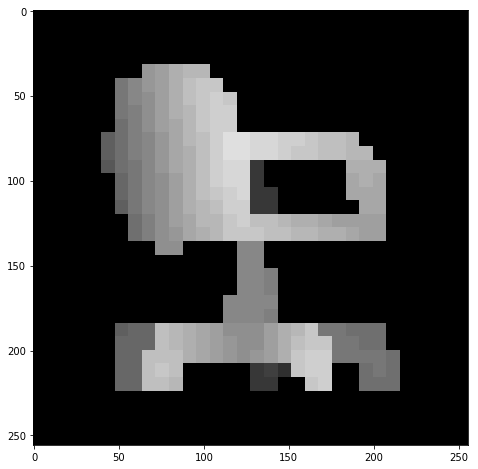

Plotting voxels...


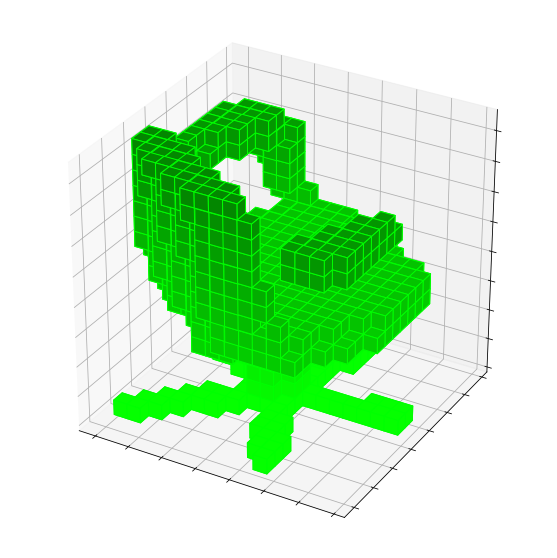

In [0]:
# Get a batch of data
data = next(iter(data_loader_train))
data.cuda()

voxels = data

imgs = get_2d_view(voxels,dir='front',output='numpy')

plt.figure()

for i in range(1):
  plt.figure(figsize=(8,8))
  plt.imshow(imgs[i,...])
  plt.show()
  
  plot_voxels(voxels[i,...])

### Discriminator training

In [0]:
"""#### Train discriminator for a single batch

* D        Discriminator model
* G        Generator model
* d_opt    Discriminator optimizer
* X        Batch of real data
"""

# Adapted from https://github.com/EmilienDupont/wgan-gp/blob/master/training.py#L73
def _gradient_penalty(real_data, generated_data, D):
    batch_size = real_data.size()[0]

    generated_data = torch.squeeze(generated_data)
    # Calculate interpolation
    alpha = torch.rand(batch_size, 1, 1, 1)
    alpha = alpha.expand_as(real_data)
    alpha = alpha.cuda()
    #print("alpha size: {}".format(alpha.shape))
    #print("real_data size: {}".format(real_data.shape))
    #print("generated_data size: {}".format(generated_data.shape))
    interpolated = alpha * real_data.data + (1 - alpha) * generated_data.data
    #print("interpolated shape: {}".format(interpolated.shape))
    interpolated = Variable(interpolated, requires_grad=True)
    interpolated = interpolated.cuda()

    # Calculate probability of interpolated examples
    #print("interpolated shape: {}".format(interpolated.shape))
    prob_interpolated = D(interpolated)

    # Calculate gradients of probabilities with respect to examples
    gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                           grad_outputs=torch.ones(prob_interpolated.size()).cuda(),
                           create_graph=True, retain_graph=True)[0]

    # Gradients have shape (batch_size, num_channels, img_width, img_height),
    # so flatten to easily take norm per example in batch
    gradients = gradients.view(batch_size, -1)
    # Use for recording only:
    #self.losses['gradient_norm'].append(gradients.norm(2, dim=1).mean().data[0])

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

    # Return gradient penalty
    return GRAD_PENALTY * ((gradients_norm - 1) ** 2).mean()

def train_batch_d(D, G, d_opt, X):
    #print("Training discriminator...")
    
    # WGAN-GP discriminator training
    # https://github.com/EmilienDupont/wgan-gp/blob/master/training.py#L29

    d_opt.zero_grad()
    
    z = torch.randn(BATCH_SIZE, Z_SIZE, 1, 1, 1).cuda()

    g_output = G(z).detach()
    d_fake = D(g_output)
    d_real = D(X)
    
    d_fake_mean = d_fake.mean()
    d_real_mean = d_real.mean()
    gradient_penalty = _gradient_penalty(X, g_output, D)
    
    #print("d_fake_mean:{} d_real_mean:{} gradient_penalty:{}".format(d_fake_mean.item(),d_real_mean.item(),gradient_penalty.item()))
    d_loss = d_fake_mean - d_real_mean + gradient_penalty
    d_loss.backward()

    # Combine losses
    # Troubleshooting: the loss result should be a single scalar value but is coming out as a 32-length tensor
    #d_loss =  d_real - d_fake    
    #d_loss.backward(ones)

    # Line 6 of WGAN Algorithm 1, update weights
    d_opt.step()

    return d_loss.item()
  
def train_batch_d_using_e(D, G, d_opt, X, E):
    #print("Training discriminator...")
    
    # WGAN-GP discriminator training
    # https://github.com/EmilienDupont/wgan-gp/blob/master/training.py#L29

    d_opt.zero_grad()
    
    #z = torch.randn(BATCH_SIZE, Z_SIZE, 1, 1, 1).cuda()

    img_2d = get_2d_view(X)
    e_out = E(img_2d)
    g_output = G(e_out).detach()
    d_fake = D(g_output)
    d_real = D(X)
    
    d_fake_mean = d_fake.mean()
    d_real_mean = d_real.mean()
    gradient_penalty = _gradient_penalty(X, g_output, D)
    
    #print("d_fake_mean:{} d_real_mean:{} gradient_penalty:{}".format(d_fake_mean.item(),d_real_mean.item(),gradient_penalty.item()))
    d_loss = d_fake_mean - d_real_mean + gradient_penalty
    d_loss.backward()

    # Combine losses
    # Troubleshooting: the loss result should be a single scalar value but is coming out as a 32-length tensor
    #d_loss =  d_real - d_fake    
    #d_loss.backward(ones)

    # Line 6 of WGAN Algorithm 1, update weights
    d_opt.step()

    return d_loss.item()

### Generator training

In [0]:
"""#### Train the generator for a single batch

* `D`: Discriminator model
* `G`: Generator model
* `g_opt`: Generator optimizer

Based on:
https://github.com/EmilienDupont/wgan-gp/blob/master/training.py#L56

"""

def train_batch_g(D, G, g_opt):
    #print("Training generator...")
    
    # https://github.com/martinarjovsky/WassersteinGAN/blob/master/main.py#L215
     
    # Reset gradients (compute them from scratch instead of accumulating)
    # Note: can call any time before loss.backward()
    g_opt.zero_grad()
    
    # Line 9 of WGAN Algorithm 1, get noise vector 
    # Not sure why Variable is used here (something about not storing the entire graph)
    z = torch.randn(BATCH_SIZE, Z_SIZE, 1, 1, 1).cuda()
    
    # Line 10 of WGAN Algorithm 1, f_w(g_theta(z)
    # Note: The mean isn't calculated in the WGAN author's implementation
    #g_loss = D(G(z))
    
    # Calculate gradients
    # Line 10 of WGAN Algorithm 1, calculate gradients
    g_output = G(z)
    g_loss = -D(g_output).mean()
    #g_loss.backward(ones)
    g_loss.backward()
    
    # Line 10 of WGAN Algorithm 1, update parameters/weights
    g_opt.step()
    
    return g_loss.mean().item()
  
def train_batch_g_using_e(D, G, g_opt,E,X):
    #print("Training generator...")
    
    # https://github.com/martinarjovsky/WassersteinGAN/blob/master/main.py#L215
     
    # Reset gradients (compute them from scratch instead of accumulating)
    # Note: can call any time before loss.backward()
    g_opt.zero_grad()
    
    img_2d = get_2d_view(X)
    e_out = E(img_2d).detach()
    g_output = G(e_out)
    g_loss = -D(g_output).mean()
    #g_loss.backward(ones)
    g_loss.backward()
    
    # Line 10 of WGAN Algorithm 1, update parameters/weights
    g_opt.step()
    
    return g_loss.mean().item()

### Generator and Discriminator training

In [0]:
"""Train generator and discriminator networks

* G          Generator model instance
* g_opt      Generator optimizer
* D          Discriminator model instance
* d_opt      Discriminator optimizer instance
* loader     Data loader instance
* n_gen_iters Number of iterations of the generator for which to train"""

def train_d_and_g(G, g_opt,
          D, d_opt,
          loader, n_gen_iters, start_gen_iter=0, start_enc_iter=0):
  
    print("Training model for {} gen_iters and with BATCH_SIZE={}...".format(n_gen_iters,BATCH_SIZE))
    print("Saving checkpoint every {} gen_iters.".format(CHECKPOINT_FREQ))
    
    t_start_total = time.time()
    
    for gen_iter in range(start_gen_iter,n_gen_iters):            
        # Train discriminator
        # Set requires_grad to True for Discrinator
        for p in D.parameters():
          p.requires_grad = True
        if gen_iter < 25 or gen_iter % 500 == 0:
          print("INFO: Training discriminator {} times...".format(D_ITERS_START))
          d_iters_temp = D_ITERS_START
        else:
          d_iters_temp = D_ITERS
        for d_iter in range(d_iters_temp):
          X = next(iter(loader))
          d_loss = train_batch_d(D, G, d_opt, X)

        # Train generator
        # Set requires_grad to False for generator to avoid computation of them
        for p in D.parameters():
          p.requires_grad = False
        g_loss = train_batch_g(D, G, g_opt)

        # Append losses to list to log losses over time
        # Note: Cast loss to float to prevent accumulation of GPU memory

        # Print stats
        #d_variance = np.var(d_losses[-10:])
        t_elapsed_hrs = (time.time() - t_start_total)/3600
        
        print("Gen iter: {}  Dloss: {:.8f} Gloss: {:.8f}   t-elapsed: {:.2f}hr".format(
            gen_iter, d_loss, g_loss,t_elapsed_hrs))

        # Save the model and print some test images
        if(gen_iter % CHECKPOINT_FREQ == 0):
            save_checkpoint(encoder,generator,discriminator,e_opt,g_opt,d_opt,gen_iter,e_iter)
            save_test_imgs(G,gen_iter,num_test_imgs=1)
            save_test_output(G,gen_iter,num_test_imgs=1)
            
            print('Copying models and images to Google Drive...')
            !cp -a "/content/3dgan-pytorch/models/." "/content/gdrive/My Drive/ECE4095-FYP/3dgan-pytorch/models"
            !cp -a "/content/3dgan-pytorch/test_imgs/." "/content/gdrive/My Drive/ECE4095-FYP/3dgan-pytorch/test_imgs"
            print('Done.')
    print("Finished training after {} epochs {}.".format(n_gen_iters))

### Encoder training

In [0]:
def train_batch_e(D,G,E,e_opt,e_loss_fn,X):
  # Todo: precompute this step
  # 1. Get 2D renderings corresponding to the 3D volumes.
  img_2d = get_2d_view(X)
  #print("img_2d type (train_batch_e()): {}".format(img_2d.type()))
  
  # 2. Input 2D images into the encoder network, then the generator, then the discriminator.
  e_out = E(img_2d)
  g_out = G(e_out)
  d_out = D(g_out)
  
  # 3. Compute the reconstruction loss Lreconstruction between the real and fake 3D volumes.
  loss_recon = e_loss_fn(g_out, X) # input, target
  
  # 4. Compute the critic loss Lcritic using the two discriminator outputs.
  loss_crtic = d_out.mean()
  
  # 5. Combine the reconstruction and WGAN-GP losses to get the overall loss L.
  print("loss_recon: {} loss_critic: {}".format(loss_recon,loss_crtic))
  loss = ALPHA1*loss_recon + ALPHA2*loss_crtic
  
  # 6. Calculate the gradient of the loss all the way back to the Encoder network.
  loss.backward()
  
  # 7. Only update the parameters of the encoder network, while keeping the parameters of the generator and discriminator networks fixed.
  e_opt.step()
  
  return loss.item()

In [0]:
def train_encoder(E,G,D,e_opt,e_loss_fn,loader,start_gen_iter=0, start_enc_iter=0):
  print("Training encoder for {} iterations...".format(N_ENCODER_ITERS))
  print("Saving checkpoint every {} iterations.".format(CHECKPOINT_FREQ))
  t_start_total = time.time()

  for enc_iter in range(start_enc_iter,N_ENCODER_ITERS):   
    X = next(iter(loader))
    X = X.cuda()
    e_loss = train_batch_e(D,G,E,e_opt,e_loss_fn,X)
    t_elapsed_hrs = (time.time() - t_start_total)/3600
    print("Iter: {}  Eloss: {:.8f} t-elapsed: {:.2f}hr".format(enc_iter, e_loss, t_elapsed_hrs))
  
    # Save models and test images
    if(enc_iter % CHECKPOINT_FREQ == 0):
        save_checkpoint(encoder,generator,discriminator,e_opt,g_opt,d_opt,start_gen_iter,enc_iter)
    if(enc_iter % IMAGE_SAVE_FREQ == 0):
        save_encoder_test_imgs(loader, E, G, enc_iter)

### E,G,D training

In [0]:
def train_e_g_d(E,G,D,e_opt,g_opt,d_opt,e_loss_fn,loader,start_gen_iter=0, start_enc_iter=0):
  print("Training encoder for {} iterations...".format(N_ENCODER_ITERS))
  print("Saving checkpoint every {} iterations.".format(CHECKPOINT_FREQ))
  t_start_total = time.time()
  n_gen_iters = N_GEN_ITERS
  
  
  E = E.cuda()
  G = G.cuda()
  D = D.cuda()
  
  enc_iter = start_enc_iter
  
  for gen_iter in range(start_gen_iter,n_gen_iters):            
    # Train discriminator
    # Set requires_grad to True for Discrinator
    for p in D.parameters():
      p.requires_grad = True
    if gen_iter < 25 or gen_iter % 500 == 0:
      print("INFO: Training discriminator {} times...".format(D_ITERS_START))
      d_iters_temp = D_ITERS_START
    else:
      d_iters_temp = D_ITERS
    for d_iter in range(d_iters_temp):
      X = next(iter(loader))
      X = X.cuda()
      d_loss = train_batch_d_using_e(D, G, d_opt, X, E)

    # Train generator
    # Set requires_grad to False for generator to avoid computation of them
    for p in D.parameters():
      p.requires_grad = False
    g_loss = train_batch_g_using_e(D, G, g_opt, E,X)
    
    e_loss = train_batch_e(D,G,E,e_opt,e_loss_fn,X)
    t_elapsed_hrs = (time.time() - t_start_total)/3600
    print("Iter: {}".format(gen_iter))
  
    
    # Save models and test images
    if(enc_iter % CHECKPOINT_FREQ == 0):
        save_checkpoint(encoder,generator,discriminator,e_opt,g_opt,d_opt,start_gen_iter,enc_iter)
    if(enc_iter % IMAGE_SAVE_FREQ == 0):
        save_encoder_test_imgs(loader, E, G, enc_iter)
    
    enc_iter = enc_iter + 1

# Run training

## Instantiate models and optimizers

In [0]:
# Initialise generator model, optimizer and loss function
print("Initialising generator...")
generator = Generator()
generator = generator.cuda()
#print(generator)
g_opt = torch.optim.Adam(generator.parameters(), lr=G_LR)
start_gen_iter = 0

# Initialise discriminator model, optimizer and loss function
print("Initialising discriminator...")
discriminator = Discriminator()
discriminator = discriminator.cuda()
#print(discriminator)
d_opt = torch.optim.Adam(discriminator.parameters(), lr=D_LR)

# instantiate encoder model and optimizer
encoder = Encoder()
encoder = encoder.cuda()
e_opt = torch.optim.Adam(encoder.parameters(), lr=E_LR)
e_loss_fn = nn.L1Loss()
start_e_iter = 0

Initialising generator...
Initialising discriminator...


### Resume training from checkpoint

In [0]:
encoder, generator, discriminator, e_opt, g_opt, d_opt, start_gen_iter, start_enc_iter = restore_checkpoint(encoder, generator, discriminator, e_opt, g_opt, d_opt, CHECKPOINT_PATH)

Loading from checkpoint...


## Run G and D Training

In [0]:
generator.train()
discriminator.train()

train_d_and_g(generator, g_opt,
      discriminator, d_opt,
      data_loader_train, N_GEN_ITERS, start_gen_iter=start_gen_iter)

Discriminator(
  (conv1): Conv3d(1, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (norm1): LayerNorm((32, 16, 16, 16), eps=1e-05, elementwise_affine=True)
  (actv1): LeakyReLU(negative_slope=0.2)
  (conv2): Conv3d(32, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (norm2): LayerNorm((64, 8, 8, 8), eps=1e-05, elementwise_affine=True)
  (actv2): LeakyReLU(negative_slope=0.2)
  (conv3): Conv3d(64, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (norm3): LayerNorm((128, 4, 4, 4), eps=1e-05, elementwise_affine=True)
  (actv3): LeakyReLU(negative_slope=0.2)
  (conv4): Conv3d(128, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (norm4): LayerNorm((256, 2, 2, 2), eps=1e-05, elementwise_affine=True)
  (actv4): LeakyReLU(negative_slope=0.2)
  (conv5): Conv3d(256, 1, kernel_size=(4, 4, 4), stride=(1, 1, 1), padding=(1, 1, 1))
)

## Run encoder training

In [0]:
encoder.train()
train_encoder(encoder,generator,discriminator,e_opt,e_loss_fn,data_loader_train,start_gen_iter=start_gen_iter, start_enc_iter=start_enc_iter)

In [0]:
#save_encoder_test_imgs(data_loader_train, encoder,generator, 0)

## Run E, G, D training

Training encoder for 10000 iterations...
Saving checkpoint every 1000 iterations.
INFO: Training discriminator 100 times...
loss_recon: 0.02203243598341942 loss_critic: -112.39506530761719
Iter: 8000
Saving checkpoint...
Copying checkpoint to Google Drive...
Saving encoder test images...


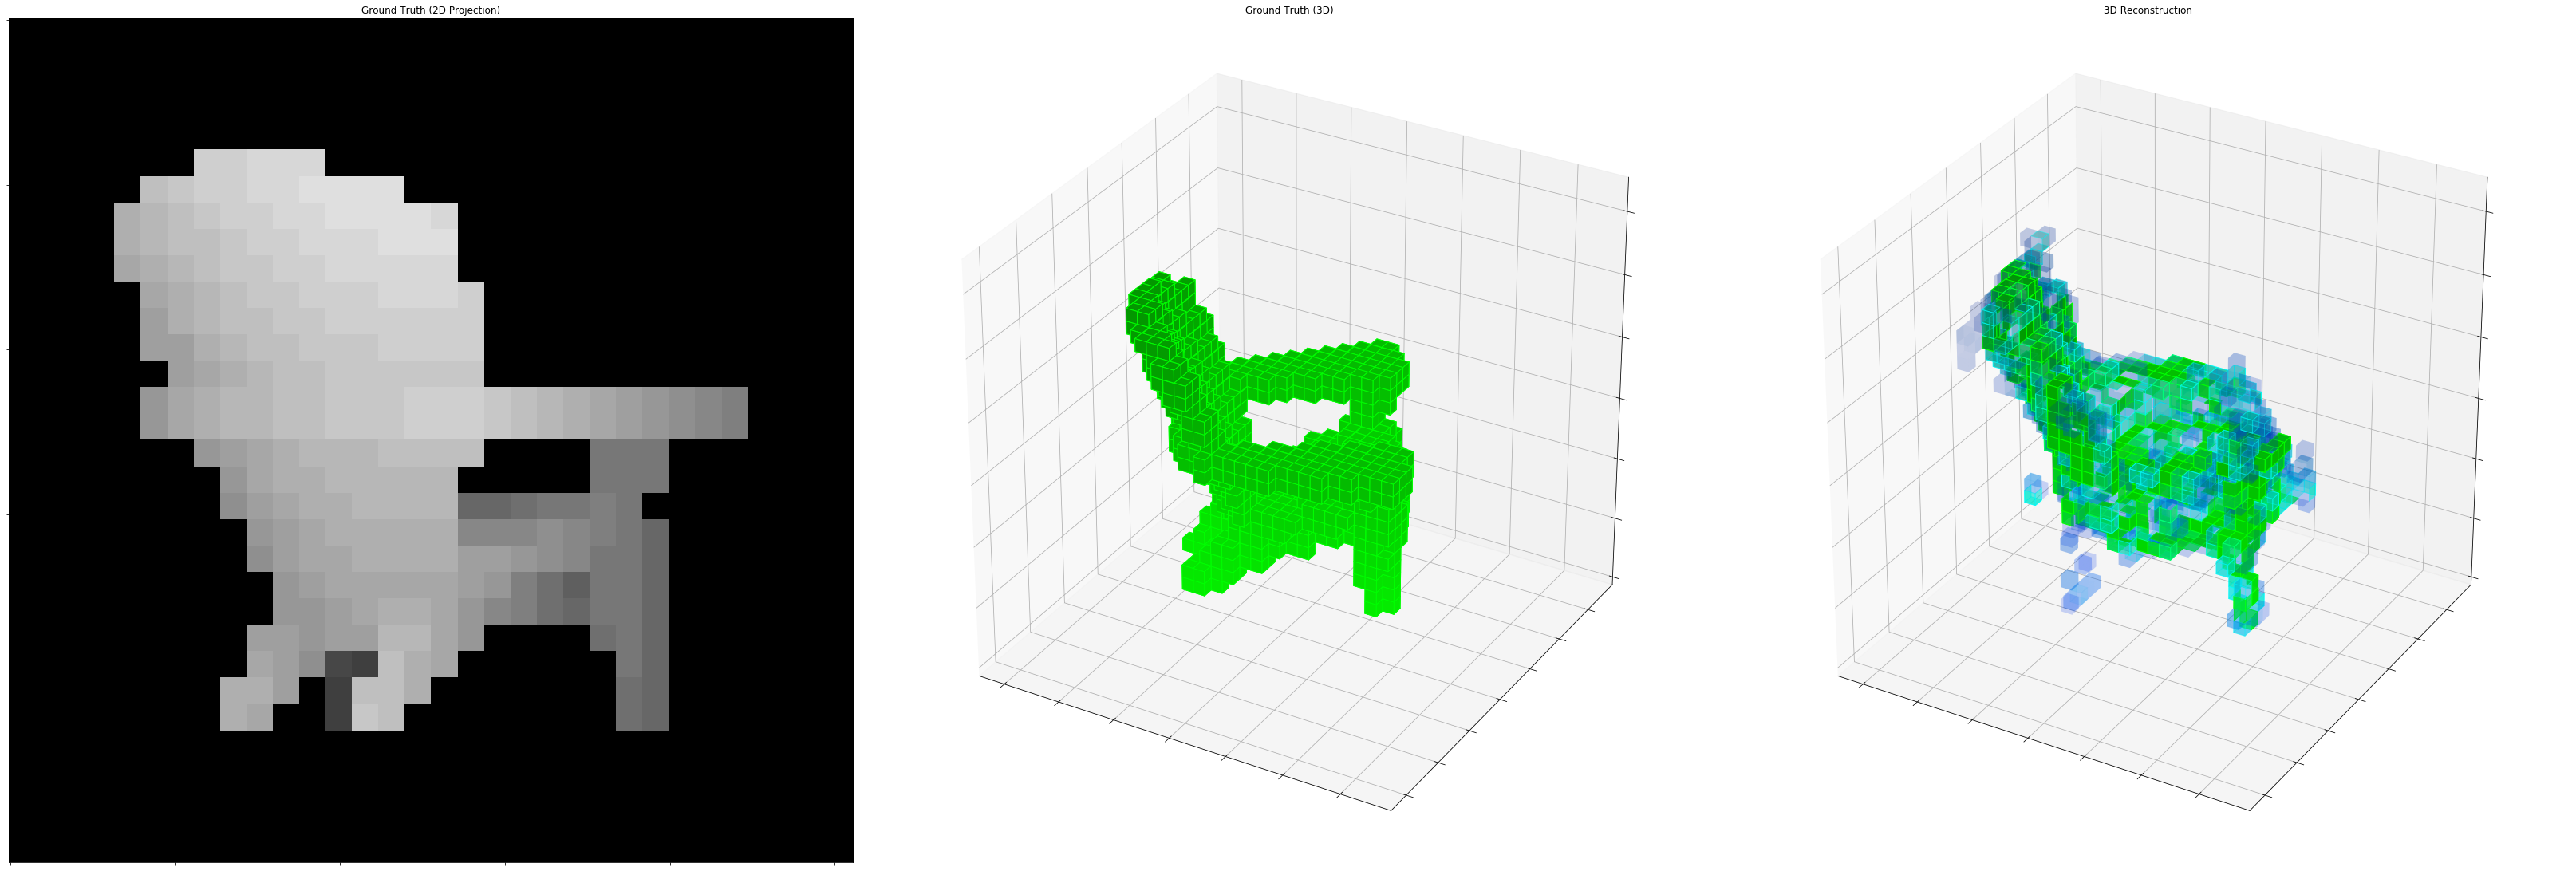

Copying images to Google Drive...
loss_recon: 0.021977799013257027 loss_critic: -111.1553955078125
Iter: 8001
loss_recon: 0.022115884348750114 loss_critic: -110.53687286376953
Iter: 8002
loss_recon: 0.024881485849618912 loss_critic: -111.2016372680664
Iter: 8003
loss_recon: 0.02350204437971115 loss_critic: -112.62345886230469
Iter: 8004
loss_recon: 0.027601154521107674 loss_critic: -112.63993835449219
Iter: 8005
loss_recon: 0.027467278763651848 loss_critic: -114.62875366210938
Iter: 8006
loss_recon: 0.028331980109214783 loss_critic: -116.08132934570312
Iter: 8007
loss_recon: 0.029839152470231056 loss_critic: -119.27442932128906
Iter: 8008
loss_recon: 0.03123251162469387 loss_critic: -117.48052978515625
Iter: 8009
loss_recon: 0.03049461543560028 loss_critic: -117.469970703125
Iter: 8010
loss_recon: 0.029323788359761238 loss_critic: -116.94363403320312
Iter: 8011
loss_recon: 0.028618372976779938 loss_critic: -110.73106384277344
Iter: 8012
loss_recon: 0.028206948190927505 loss_critic: -10

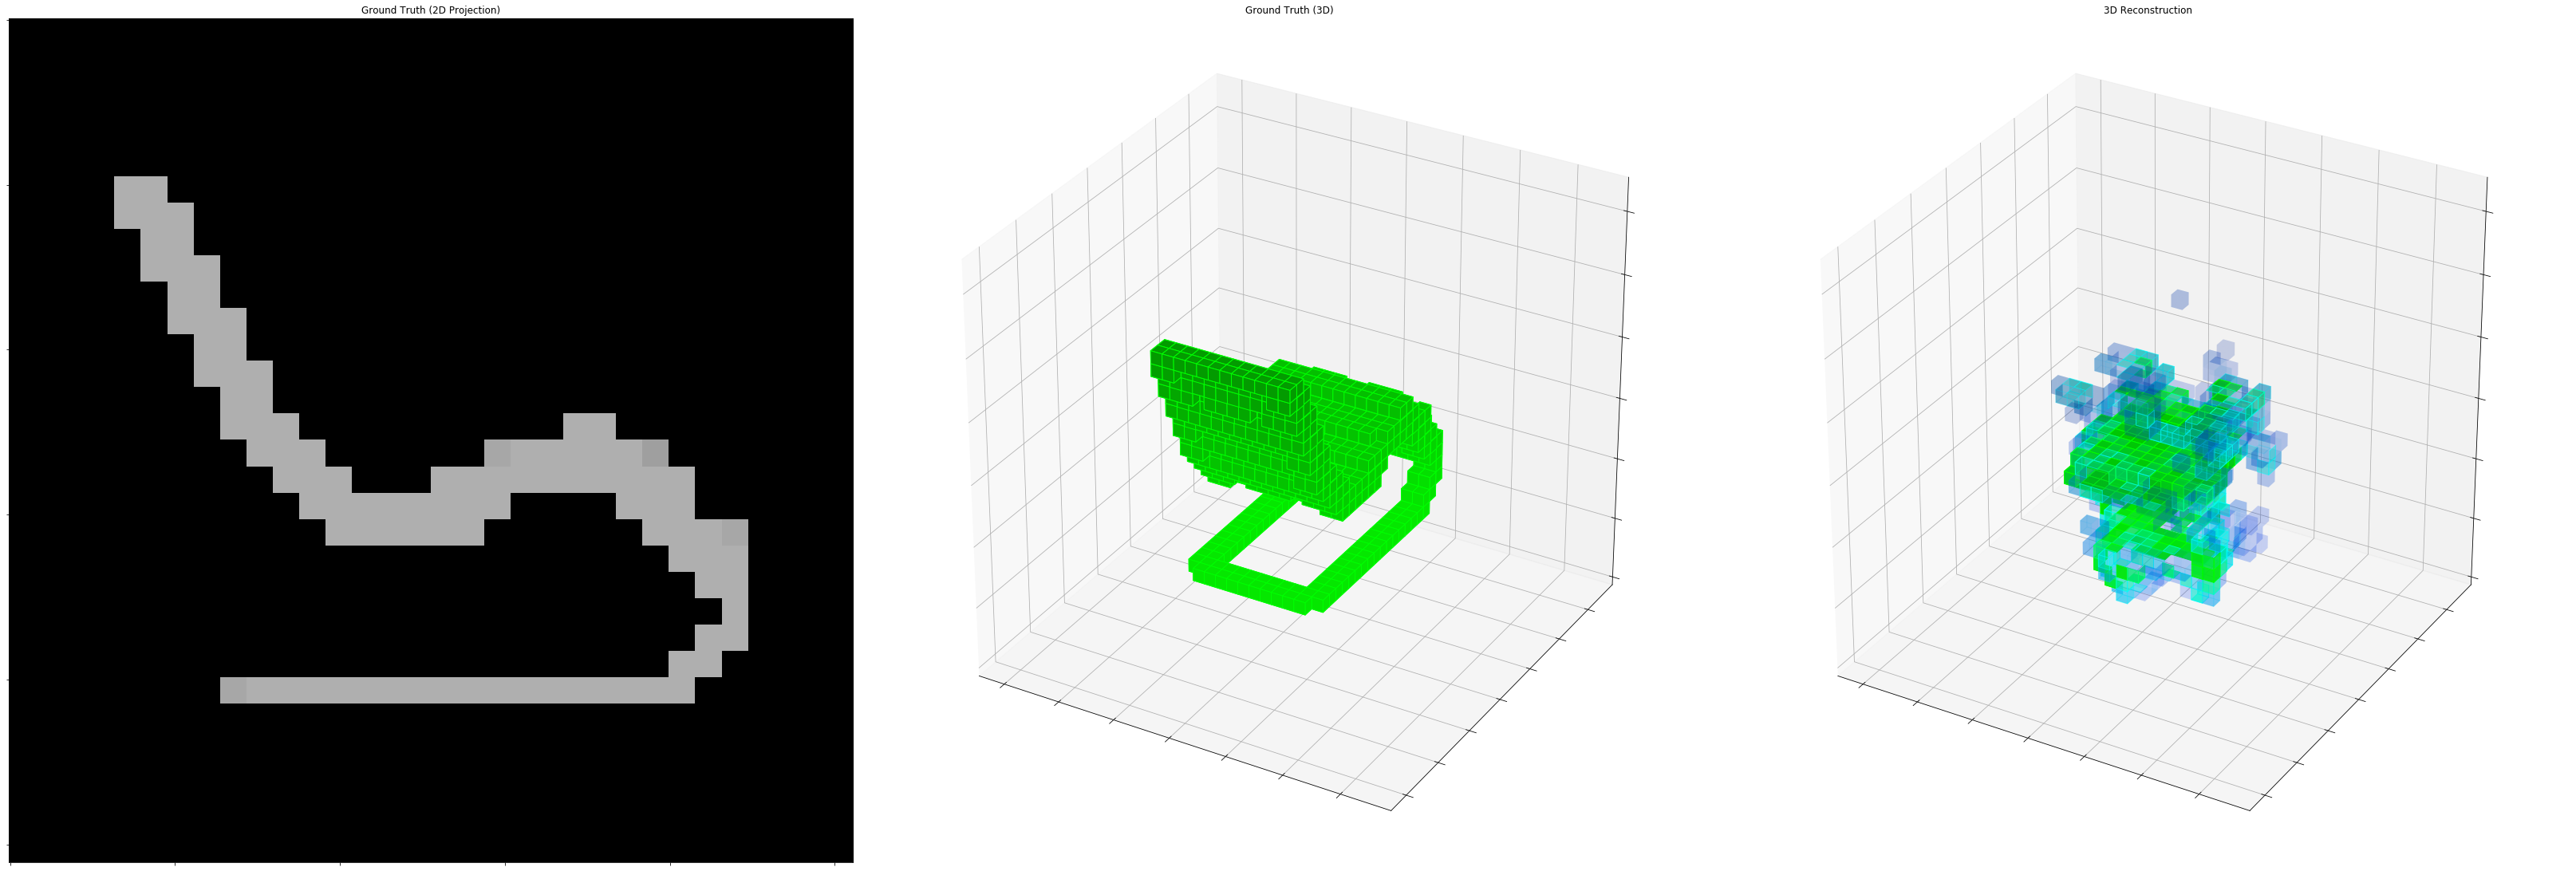

Copying images to Google Drive...
loss_recon: 0.02424582466483116 loss_critic: -122.11766815185547
Iter: 8251
loss_recon: 0.023602303117513657 loss_critic: -122.5653076171875
Iter: 8252
loss_recon: 0.025031842291355133 loss_critic: -122.73110961914062
Iter: 8253
loss_recon: 0.025452181696891785 loss_critic: -122.55314636230469
Iter: 8254
loss_recon: 0.02421664632856846 loss_critic: -124.11973571777344
Iter: 8255
loss_recon: 0.024179017171263695 loss_critic: -126.2173843383789
Iter: 8256
loss_recon: 0.022983158007264137 loss_critic: -127.65912628173828
Iter: 8257
loss_recon: 0.0253136046230793 loss_critic: -124.30119323730469
Iter: 8258
loss_recon: 0.02394085004925728 loss_critic: -123.0798110961914
Iter: 8259
loss_recon: 0.024999253451824188 loss_critic: -124.47062683105469
Iter: 8260
loss_recon: 0.023641541600227356 loss_critic: -122.95892333984375
Iter: 8261
loss_recon: 0.02460619807243347 loss_critic: -124.9134292602539
Iter: 8262
loss_recon: 0.027935151010751724 loss_critic: -122.9

In [0]:
train_e_g_d(encoder,generator,discriminator,e_opt,g_opt,d_opt,e_loss_fn,data_loader_train,start_gen_iter=8000, start_enc_iter=10000)

In [0]:
save_test_output(generator,8000,num_test_imgs=10)